# Machine Learning Modeling 
* `non-stationary` & `highly-correlated` 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
pd.set_option("max_rows", 500)
pd.set_option("max_columns", 500)
pd.set_option('float_format', '{:f}'.format)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)


import dataload

import os 
import random
import datetime
from tqdm import tqdm 
from functools import reduce

# modeling 
from tslearn.clustering import TimeSeriesKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

import shap 

In [2]:
nonst_high = pd.read_csv("nonst_high_0616.csv", encoding="cp949")
weather = pd.read_csv("weather_final2.csv", encoding="cp949")
loc_weight = pd.read_csv("population_wieght.csv", encoding="cp949")

print(nonst_high.shape, weather.shape, loc_weight.shape)

print("*", nonst_high.sm_cat.nunique())
nonst_high.head()

(1179438, 52) (11680, 29) (9, 2)
* 176


,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
0,2018-01-01,1,냉난방가전,가열식 가습기,1.000000,24.759610,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,17.938930,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,2018-01-01,1,냉난방가전,가열식 가습기,3.000000,11.070550,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,12.605040,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,4.255310,13.927120,5.478870,0.000000,0.000000,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [271]:
nonst_high.rn_day.describe()

count   913113.000000
mean         3.113759
std          8.017261
min          0.000000
25%          0.000000
50%          0.055000
75%          1.391063
max         72.181625
Name: rn_day, dtype: float64

In [4]:
nonst_high = nonst_high[nonst_high.qty > 0]
print(nonst_high.shape)
print("*", nonst_high.sm_cat.nunique())

(987563, 52)
* 176


In [5]:
tqdm.pandas()
nonst_high['date'] = nonst_high['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
weather['날짜'] = weather['날짜'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
weather = weather.rename(columns={"날짜" : "date"})

100%|██████████| 11680/11680 [00:00<00:00, 14132.91it/s]


# TimeSeries Clustering 

In [172]:
nonst_high['year'] = nonst_high['date'].progress_apply(lambda x : x.year)
buy_2018 = nonst_high[nonst_high.year==2018][['date', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = nonst_high[nonst_high.year==2019][['date', 'big_cat', 'sm_cat', 'qty']]
nonst_high = nonst_high.drop('year', axis=1)

buy_2018.shape, buy_2019.shape

100%|██████████| 1179438/1179438 [00:04<00:00, 271024.22it/s]


((586427, 4), (593011, 4))

In [173]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

100%|██████████| 586427/586427 [00:02<00:00, 253358.20it/s]


In [174]:
buy_2018.date.nunique()

365

In [175]:
buy_2018["date"] = buy_2018["date"].apply(lambda x : str(x)[5:])
buy_2019["date"] = buy_2019["date"].apply(lambda x : str(x)[5:])

In [176]:
buy_2018 = pd.pivot_table(buy_2018, index="sm_cat", columns="date", values="qty")
buy_2019 = pd.pivot_table(buy_2019, index="sm_cat", columns="date", values="qty")

print(buy_2018.shape, buy_2019.shape)

buy_2018 = buy_2018.fillna(0)
buy_2019 = buy_2019.fillna(0)

(176, 365) (176, 365)


In [177]:
buy_2018.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

## 1. 데이터 정규화 

In [178]:
def normalize_df(df) : 
    avg_lst = []; std_lst = []
    for idx, row in tqdm(df.iterrows()):
        avg_lst.append(row.mean())
        std_lst.append(row.std())

    df['avg'] = avg_lst
    df['std'] = std_lst


    for i in tqdm(range(len(df))):
        for j in range(365):
            df.iloc[i,j] = (df.iloc[i,j] - df.iloc[i,365])/df.iloc[i,366] 

    df = df.drop(['avg','std'], axis=1)
    return df 

In [179]:
buy_2018 = normalize_df(buy_2018)
buy_2019 = normalize_df(buy_2019)

176it [00:00, 7037.76it/s]
100%|██████████| 176/176 [00:09<00:00, 17.96it/s]
176it [00:00, 8348.38it/s]
100%|██████████| 176/176 [00:09<00:00, 18.33it/s]


In [182]:
ts = (buy_2018 + buy_2019)/2
ts.shape

(176, 365)

## 2. 최적 k 찾기 

In [181]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)): 
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(2, 7), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

100%|██████████| 5/5 [03:06<00:00, 37.38s/it]


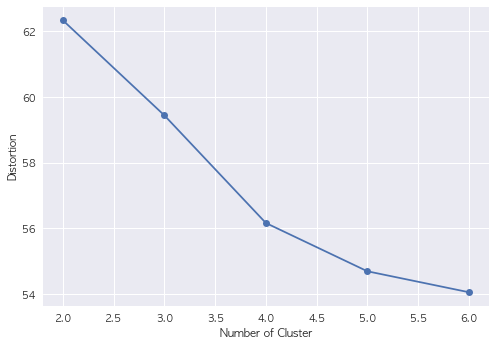

CPU times: user 8min 56s, sys: 1min 12s, total: 10min 8s
Wall time: 3min 6s


In [185]:
%time  visualize_elbowmethod(ts)

## 3. TimeSeries K-means Clustering 

In [186]:
model1 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=300, random_state=1234, n_jobs=-1)

for i in tqdm(range(len(ts))) : 
    model1.fit(ts)

100%|██████████| 176/176 [1:39:57<00:00, 34.08s/it]


In [187]:
ts_result = pd.DataFrame({
    'sm_cat' : ts.index, 
    'cluster' : model1.labels_
})

In [188]:
ts_result.cluster.value_counts()

0    66
3    42
1    41
2    27
Name: cluster, dtype: int64

In [189]:
# cluster 0 : 여름 (66)
ts_result[ts_result.cluster==0]

,sm_cat,cluster
1,감/홍시,0
4,감자,0
6,건대추,0
7,건포도,0
12,계란,0
13,고추/피망/파프리카,0
15,공기정화 용품,0
27,기타 주스류,0
28,김치류,0
32,남성 선케어,0


In [190]:
# cluster 1 
ts_result[ts_result.cluster==1]

,sm_cat,cluster
10,견과류 땅콩,1
16,과채 음료/주스,1
19,기능성 아이케어 화장품,1
22,기초 화장용 로션,1
23,기초 화장용 미스트,1
24,기초 화장용 에센스,1
30,남성 로션,1
31,남성 메이크업,1
33,남성 세트,1
34,남성 쉐이빙,1


In [191]:
# cluster 2 
ts_result[ts_result.cluster==2]

,sm_cat,cluster
5,갓김치,2
9,견과류,2
20,기능성 영양보습 화장품,2
42,다이어트보조식,2
44,닭 양념육,2
46,더치커피,2
64,바나나/파인애플/망고,2
66,바디 세트,2
72,백김치,2
76,벽걸이형 냉온풍기,2


In [192]:
# cluster 3 
ts_result[ts_result.cluster==3]

,sm_cat,cluster
0,가열식 가습기,3
2,감귤/한라봉/오렌지,3
3,감말랭이,3
8,게장류,3
11,견과류 밤,3
14,곡물차,3
17,국내산 돈육,3
18,굴 생물,3
21,기능성 화장품 세트,3
25,기초 화장용 오일/앰플,3


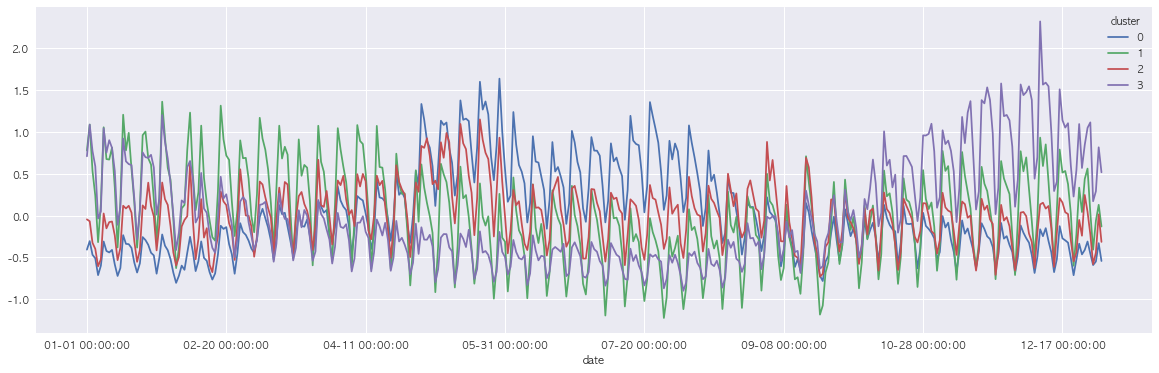

In [193]:
ts["cluster"] = model1.labels_

plt.rcParams["figure.figsize"]=(20,6)
ts.groupby(['cluster']).mean().T.plot()
plt.show()

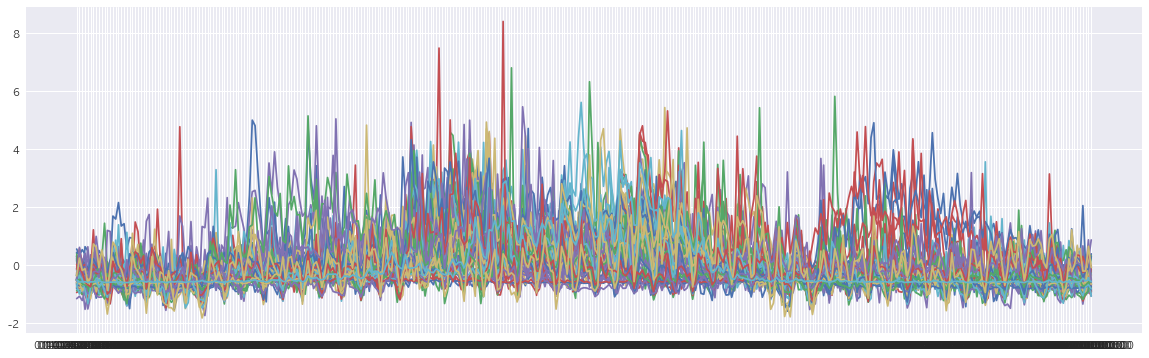

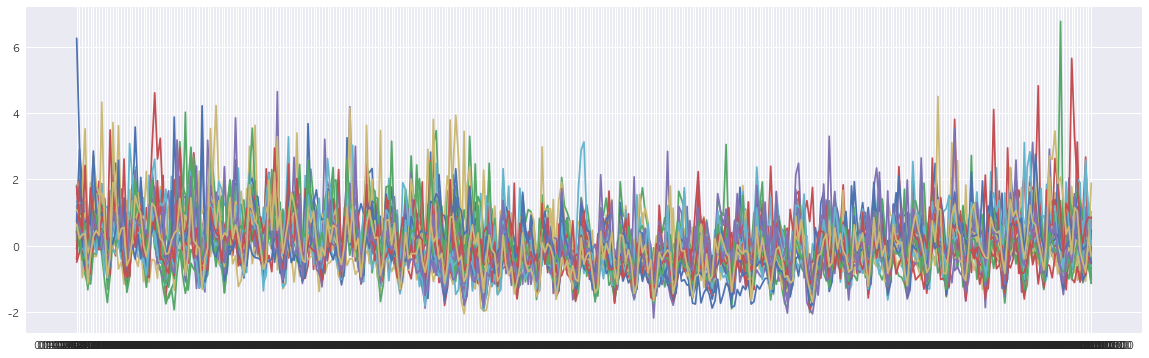

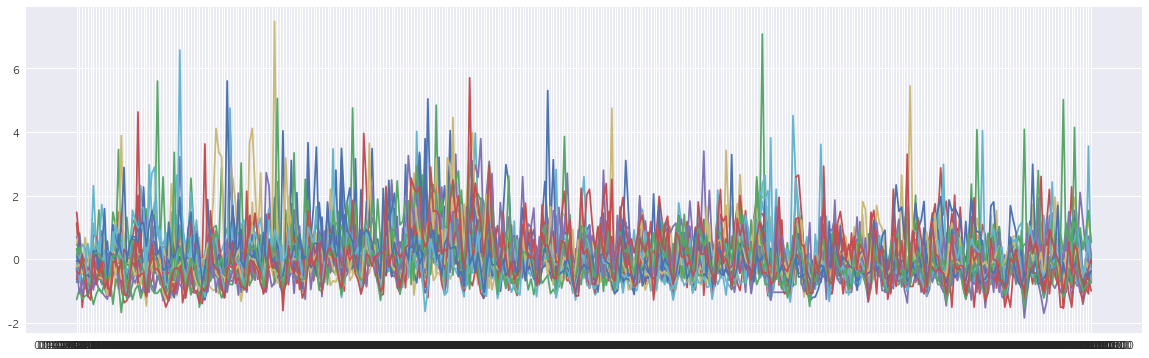

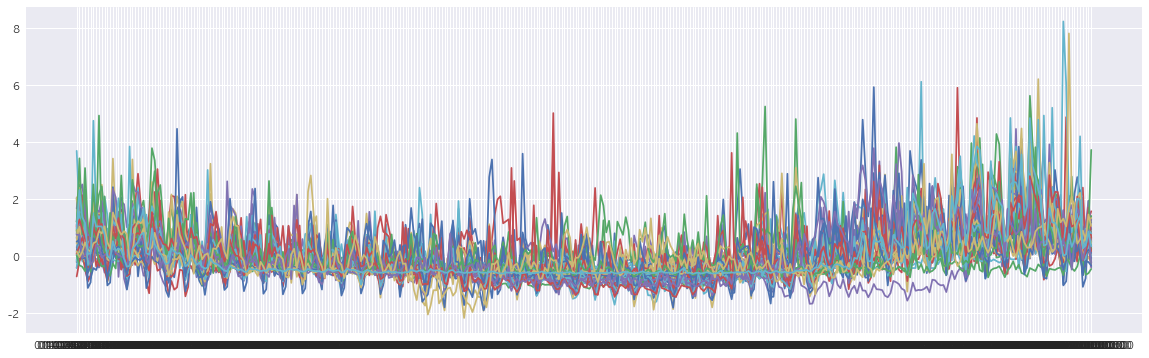

In [194]:
for i in range(4):
    clusters = ts[ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

In [195]:
ts["cluster"] = model1.labels_
ts.to_csv("tsclustering_0617.csv", encoding='cp949')

In [6]:
ts = pd.read_csv("tsclustering_0617.csv", encoding='cp949')

# Modeling 

In [7]:
def region_weather(loc):
    weather_true = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절', 'year', 'month'], axis=1) 
    weather1 = pd.pivot_table(weather_true[weather_true['지역'] == loc], index='date', columns='지역').reset_index(level=0)
    weather1.columns = weather1.columns.get_level_values(0)
    return weather1

In [8]:
def cluster_df(big_cat, product_cat) : 
    
    '''
    big_cat : TimeSeries Clustering 결과 파일 (pivot table 형태의 dataframe)
    product_cat : big_category 에 해당되는 dataframe 
    '''
    
    cluster0 = big_cat[big_cat["cluster"] == 0] 
    cluster1 = big_cat[big_cat["cluster"] == 1]
    cluster2 = big_cat[big_cat["cluster"] == 2]
    cluster3 = big_cat[big_cat["cluster"] == 3]
    
    cluster0 = list(cluster0['sm_cat']) 
    cluster1 = list(cluster1['sm_cat']) 
    cluster2 = list(cluster2['sm_cat']) 
    cluster3 = list(cluster3['sm_cat']) 
    
    product_cat = product_cat.rename(columns = {'PM10' : 'PM10_index', 'PM25' : 'PM25_index'})
    
    big_c0 = product_cat[product_cat['sm_cat'].isin(cluster0)].reset_index(drop=True)
    big_c1 = product_cat[product_cat['sm_cat'].isin(cluster1)].reset_index(drop=True)
    big_c2 = product_cat[product_cat['sm_cat'].isin(cluster2)].reset_index(drop=True)
    big_c3 = product_cat[product_cat['sm_cat'].isin(cluster3)].reset_index(drop=True)
    
    return big_c0, big_c1, big_c2, big_c3

In [9]:
bty_c0, bty_c1, bty_c2, bty_c3 = cluster_df(ts, nonst_high)
bty_c0.shape, bty_c1.shape, bty_c2.shape, bty_c3.shape

((359845, 52), (267797, 52), (139599, 52), (220322, 52))

In [10]:
# sm_cat one hot encoding 
bty_c0 = pd.get_dummies(bty_c0, columns=['sm_cat'], drop_first = True)
bty_c1 = pd.get_dummies(bty_c1, columns=['sm_cat'], drop_first = True)
bty_c2 = pd.get_dummies(bty_c2, columns=['sm_cat'], drop_first = True)
bty_c3 = pd.get_dummies(bty_c3, columns=['sm_cat'], drop_first = True)

bty_c0.shape, bty_c1.shape, bty_c2.shape, bty_c3.shape

((359845, 116), (267797, 91), (139599, 77), (220322, 92))

In [11]:
def loc_df(cluster) : 
    
    '''
    - 수도권: 서울
    - 강원: 강릉
    - 경북: 대구
    - 경남: 부산
    - 전남: 광주
    - 전북: 전주 
    - 충남: 대전
    - 충북: 청주 
    - 제주: 제주
    '''
    
    c0_1 = cluster.merge(region_weather('서울'), on="date", how='left')
    c0_2 = cluster.merge(region_weather('강릉'), on="date", how='left')
    c0_3 = cluster.merge(region_weather('대구'), on="date", how='left')
    c0_4 = cluster.merge(region_weather('부산'), on="date", how='left')
    c0_5 = cluster.merge(region_weather('광주'), on="date", how='left')
    c0_6 = cluster.merge(region_weather('전주'), on="date", how='left')
    c0_7 = cluster.merge(region_weather('대전'), on="date", how='left')
    c0_8 = cluster.merge(region_weather('청주'), on="date", how='left')
    c0_9 = cluster.merge(region_weather('제주'), on="date", how='left')  
    
    return c0_1, c0_2, c0_3, c0_4, c0_5, c0_6, c0_7, c0_8, c0_9

In [12]:
def sampling(data):
    
    # 랜덤으로 요일 선택
    np.random.seed(1234)
    sample_day = []; sample_idx = []
    count = 730//7 
    day_list = day_list = [1,2,3,4,5,6,7]
    sample_list = [random.choice(day_list) for i in range(count)]

    # 랜덤으로 선택된 요일의 날짜
    start = datetime.datetime(2018, 1, 1)
    for days in sample_list:
        sample_day.append(start + datetime.timedelta(days = days))
        start = start + datetime.timedelta(weeks = 1)

    # 샘플링
    for date in sample_day:
        sample_idx.extend(data[data['date']==date].index)
        
    all_idx = data.index.tolist()
    train_idx = list(set(all_idx) - set(sample_idx))
    
    return data.iloc[train_idx].reset_index(drop=True), data.iloc[sample_idx].reset_index(drop=True)

In [13]:
def df_preprocessing(train, test) : 
    train = train.drop(['date', 'big_cat'], axis=1) ; test = test.drop(['date', 'big_cat'], axis=1)

    # X, y 
    X_train , y_train = train.drop('qty', axis=1), train.qty 
    X_test , y_test = test.drop('qty', axis=1), test.qty 
    
    # continuous / discrete 
    dummy = list(X_train.columns[X_train.columns.str.contains("연|월|분기|요일|공휴일여부|주말여부|계절|age|sm_cat_|강수여부|폭염여부|sex")])
    train_continuous = X_train.drop(dummy, axis=1) ; test_continuous = X_test.drop(dummy, axis=1) 
    train_discrete = X_train[dummy] ; test_discrete = X_test[dummy]
    
    # standardization 
    std_scaler = StandardScaler() 
    train_std = std_scaler.fit_transform(train_continuous) ; test_std = std_scaler.transform(test_continuous)
    train_std = pd.DataFrame(train_std, columns = train_continuous.columns) ; test_std = pd.DataFrame(test_std, columns = test_continuous.columns)
    
    # concat dummy variable 
    train_std = pd.concat([train_std, train_discrete], axis=1) ; test_std = pd.concat([test_std, test_discrete], axis=1)
        
    return train_std, y_train, test_std, y_test

# Modeling 

In [14]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [15]:
def loc_weighted_sum(df1, df2, df3, df4, df5, df6, df7, df8, df9) : 
    df = df1 * loc_weight.loc[0]["final_가중치"] + df2 * loc_weight.loc[1]["final_가중치"] + df3 * loc_weight.loc[2]["final_가중치"]
    + df4 * loc_weight.loc[3]["final_가중치"] + df5 * loc_weight.loc[4]["final_가중치"] + df6 * loc_weight.loc[5]["final_가중치"]
    + df7 * loc_weight.loc[6]["final_가중치"] + df8 * loc_weight.loc[7]["final_가중치"] + df9 * loc_weight.loc[8]["final_가중치"]       
    return df 

## 1. Cluster0 : 겨울 

In [18]:
def location_ensemble(df, model, shapvalue=False) : 
    train, test = sampling(df)
    train1, train2, train3, train4, train5, train6, train7, train8, train9 = loc_df(train) 
    test1, test2, test3, test4, test5, test6, test7, test8, test9 = loc_df(test) 
    
    if not train1.shape==train2.shape==train3.shape==train4.shape==train5.shape==train6.shape==train7.shape==train8.shape==train9.shape : 
        raise Exception("Check Again!")
    if not test1.shape==test2.shape==test3.shape==test4.shape==test5.shape==test6.shape==test7.shape==test8.shape==test9.shape : 
        raise Exception("Check Again!")

    print("Data Shape : ", train1.shape, test1.shape) 

    print("\n", "===== Finish Data Preprocessing =====")
    print()
       
        
    # 1. 서울 
    X_train1, y_train1, X_test1, y_test1 = df_preprocessing(train1, test1)
    
    model1 = model
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    
    fe1 = pd.DataFrame({'col' : X_train1.columns, 'feature importance' : model1.feature_importances_})
    fe1 = fe1[~fe1.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe1 = fe1.set_index('col').squeeze(axis=1)
    
    if shapvalue : 
        explainer = shap.TreeExplainer(model1)
        shap_values = explainer1.shap_values(X_train1)     
    
    print("* Finish 서울 *")
    
    
    # 2. 강원 
    X_train2, y_train2, X_test2, y_test2 = df_preprocessing(train2, test2)
    
    model2 = model
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)    
    
    fe2 = pd.DataFrame({'col' : X_train2.columns, 'feature importance' : model2.feature_importances_})
    fe2 = fe2[~fe2.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe2 = fe2.set_index('col').squeeze(axis=1)
    
    print("* Finish 강원 *")


    # 3. 경북 
    X_train3, y_train3, X_test3, y_test3 = df_preprocessing(train3, test3)
    
    model3 = model
    model3.fit(X_train3, y_train3)
    y_pred3 = model3.predict(X_test3)   
    
    fe3 = pd.DataFrame({'col' : X_train3.columns, 'feature importance' : model3.feature_importances_})
    fe3 = fe3[~fe3.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe3 = fe3.set_index('col').squeeze(axis=1)

    print("* Finish 경북 *")
    

    # 4. 경남 
    X_train4, y_train4, X_test4, y_test4 = df_preprocessing(train4, test4)
    
    model4 = model
    model4.fit(X_train4, y_train4)
    y_pred4 = model4.predict(X_test4) 
    
    fe4 = pd.DataFrame({'col' : X_train4.columns, 'feature importance' : model4.feature_importances_})
    fe4 = fe4[~fe4.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe4 = fe4.set_index('col').squeeze(axis=1)

    print("* Finish 경남 *")
    
    
    # 5. 전남 
    X_train5, y_train5, X_test5, y_test5 = df_preprocessing(train5, test5)
    
    model5 = model
    model5.fit(X_train5, y_train5)
    y_pred5 = model5.predict(X_test5)
    
    fe5 = pd.DataFrame({'col' : X_train5.columns, 'feature importance' : model5.feature_importances_})
    fe5 = fe5[~fe5.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe5 = fe5.set_index('col').squeeze(axis=1)
    
    print("* Finish 전남 *")
    

    # 6. 전북 
    X_train6, y_train6, X_test6, y_test6 = df_preprocessing(train6, test6)
    
    model6 = model
    model6.fit(X_train6, y_train6)
    y_pred6 = model6.predict(X_test6)
    
    fe6 = pd.DataFrame({'col' : X_train6.columns, 'feature importance' : model6.feature_importances_})
    fe6 = fe6[~fe6.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe6 = fe6.set_index('col').squeeze(axis=1)
      
    print("* Finish 전북 *")
    
    
    # 7. 충남 
    X_train7, y_train7, X_test7, y_test7 = df_preprocessing(train7, test7)
    
    model7 = model
    model7.fit(X_train7, y_train7)
    y_pred7 = model7.predict(X_test7)   
    
    fe7 = pd.DataFrame({'col' : X_train7.columns, 'feature importance' : model7.feature_importances_})
    fe7 = fe7[~fe7.col.str.contains('sm_cat_')].reset_index(drop=True) 
    fe7 = fe7.set_index('col').squeeze(axis=1)
    
    print("* Finish 충남 *")


    # 8. 충북 
    X_train8, y_train8, X_test8, y_test8 = df_preprocessing(train8, test8)
    
    model8 = model
    model8.fit(X_train8, y_train8)
    y_pred8 = model8.predict(X_test8)   
    
    fe8 = pd.DataFrame({'col' : X_train8.columns, 'feature importance' : model8.feature_importances_})
    fe8 = fe8[~fe8.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe8 = fe8.set_index('col').squeeze(axis=1)
    
    print("* Finish 충북 *")
    

    # 9. 제주 
    X_train9, y_train9, X_test9, y_test9 = df_preprocessing(train9, test9)
    
    model9 = model
    model9.fit(X_train9, y_train9)
    y_pred9 = model9.predict(X_test9) 
    
    fe9 = pd.DataFrame({'col' : X_train9.columns, 'feature importance' : model9.feature_importances_})
    fe9 = fe9[~fe9.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe9 = fe9.set_index('col').squeeze(axis=1)
    
    print("* Finish 제주 *")
    
    
    # ensemble 
    y_true = loc_weighted_sum(y_test1, y_test2, y_test3, y_test4, y_test5, y_test6, y_test7, y_test8, y_test9)
    y_pred = loc_weighted_sum(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7, y_pred8, y_pred9)
    y_pred = y_pred1.clip(0) # 0보다 작게 예측한 경우, 0으로 올림 
            
    
    print("\n", "===== Score =====")
    print("* MSE  : {:.4}".format(mean_squared_error(y_true, y_pred)))
    print("* RMSE : {:.4}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("* MAPE : {:.4}".format(MAPE(y_true, y_pred)))
    print()
    
    
    # visualize result 
    plt.figure(figsize=(20,4))
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')
    plt.legend(loc = 'best')
    plt.show()
    
    
    # feature importance 
    fe = loc_weighted_sum(fe1, fe2, fe3, fe4, fe5, fe6, fe7, fe8, fe9)
    fe = pd.DataFrame(fe)
    
    
    return y_true, y_pred, fe, explainer, shap_values, X_train1

In [23]:
def location_ensemble2(df, model, shapvalue=False) : 
    train, test = sampling(df)
    train1, train2, train3, train4, train5, train6, train7, train8, train9 = loc_df(train) 
    test1, test2, test3, test4, test5, test6, test7, test8, test9 = loc_df(test) 
    
    if not train1.shape==train2.shape==train3.shape==train4.shape==train5.shape==train6.shape==train7.shape==train8.shape==train9.shape : 
        raise Exception("Check Again!")
    if not test1.shape==test2.shape==test3.shape==test4.shape==test5.shape==test6.shape==test7.shape==test8.shape==test9.shape : 
        raise Exception("Check Again!")
        
    print("Data Shape : ", train1.shape, test1.shape) 

    print("\n", "===== Finish Data Preprocessing =====")
    print()
       
        
    # 1. 서울 
    X_train1, y_train1, X_test1, y_test1 = df_preprocessing(train1, test1)
    
    model1 = model
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    
    fe1 = pd.DataFrame({'col' : X_train1.columns, 'feature importance' : model1.feature_importances_})
    fe1 = fe1[~fe1.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe1 = fe1.set_index('col').squeeze(axis=1)
    
    if shapvalue : 
        explainer1 = shap.TreeExplainer(model1)
        shap_values1 = explainer1.shap_values(X_train1)
        
    
    print("* Finish 서울 *")
    

    # 2. 강원 
    X_train2, y_train2, X_test2, y_test2 = df_preprocessing(train2, test2)
    
    model2 = model
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)    
    
    fe2 = pd.DataFrame({'col' : X_train2.columns, 'feature importance' : model2.feature_importances_})
    fe2 = fe2[~fe2.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe2 = fe2.set_index('col').squeeze(axis=1)
    
    print("* Finish 강원 *")

    
    # ensemble 
    y_true = (y_test1 * loc_weight.loc[0]["final_가중치"] + y_test2 * loc_weight.loc[1]["final_가중치"]) / (loc_weight.loc[0]["final_가중치"] + loc_weight.loc[1]["final_가중치"])
            
    y_pred = (y_pred1 * loc_weight.loc[0]["final_가중치"] + y_pred2 * loc_weight.loc[1]["final_가중치"]) / (loc_weight.loc[0]["final_가중치"] + loc_weight.loc[1]["final_가중치"])
    y_pred = y_pred1.clip(0)
    
    
    print("\n", "===== Score =====")
    print("* MSE  : {:.4}".format(mean_squared_error(y_true, y_pred)))
    print("* RMSE : {:.4}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("* MAPE : {:.4}".format(MAPE(y_true, y_pred)))
    print()
    
    
    # visualize result 
    plt.figure(figsize=(20,4))
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')
    plt.legend(loc = 'best')
    plt.show()
    
    
    # feature importance 
    fe = (fe1 * loc_weight.loc[0]["final_가중치"] + fe2 * loc_weight.loc[1]["final_가중치"]) / (loc_weight.loc[0]["final_가중치"] + loc_weight.loc[1]["final_가중치"])   
    fe = pd.DataFrame(fe)
    
    
    return y_true, y_pred, fe, explainer1, shap_values1, X_train1

Data Shape :  (308824, 132) (51021, 132)

 ===== Finish Data Preprocessing =====

* Finish 서울 *
* Finish 강원 *

 ===== Score =====
* MSE  : 439.4
* RMSE : 20.96
* MAPE : 111.3



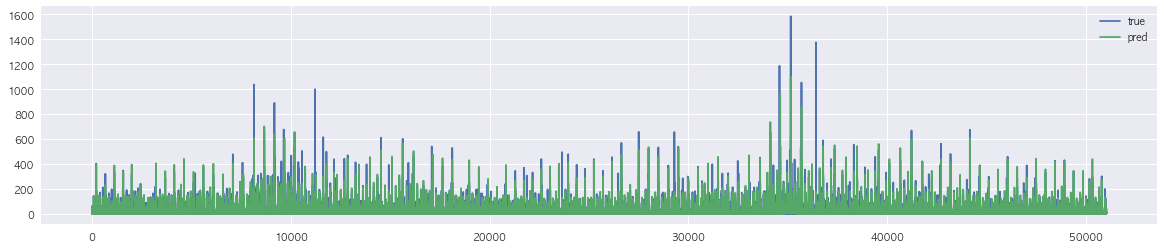

In [24]:
y_true, y_pred, fe, explainer1, shap_values1, X_train1 = location_ensemble2(bty_c0, xgb.XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=100, random_state=1234), shapvalue=True)

In [173]:
def prep_shapvalue_for_weather(shapvalue, X, product=None) : 
    # Remove Categorical Columns 
    sm_cat_idx = [i for i,c in enumerate(X.columns) if 'sm_cat_' in c]
    sm_cat_col = [c for i,c in enumerate(X.columns) if 'sm_cat_' in c]
    
    # Remove Date Columns 
    date_idx = [i for i,c in enumerate(X.columns) if '연_' in c or '월_' in c or '분기' in c or '요일_' in c or 'age_' in c or 'sex' in c or '공휴일여부' in c or '주말여부' in c or 'ratio' in c or 'cnt' in c ]
    date_col = [c for i,c in enumerate(X.columns) if '연_' in c or '월_' in c or '분기' in c or '요일_' in c or 'age_' in c or 'sex' in c or '공휴일여부' in c or '주말여부' in c or 'ratio' in c or 'cnt' in c ]
    
    # ShapValue  
    shapvalue = shapvalue[:, np.delete(np.delete(np.arange(len(X.columns)), sm_cat_idx), date_idx)]
    X2 = X.drop(sm_cat_col+date_col, axis=1)
    
    # for Product ShapValue 
    if product : 
        idx = X[X[f"sm_cat_{product}"] == 1].index
        shapvalue = shapvalue[idx, :] ; X2 = X2.loc[idx]
    
    # Error Check 
    if shapvalue.shape != X2.shape : 
        raise Exception("Check Again!")
        
    return shapvalue, X2 

In [294]:
def prep_shapvalue_for_trend(shapvalue, X, train, product=None, target=None) : 
    # Remove Categorical Columns 
    sm_cat_idx = [i for i,c in enumerate(X.columns) if 'sm_cat_' in c]
    sm_cat_col = [c for i,c in enumerate(X.columns) if 'sm_cat_' in c]
    
    # Remove Date Columns 
    date_idx = [i for i,c in enumerate(X.columns) if '연_' in c or '월_' in c or '계절' in c or '분기' in c or '요일_' in c or '공휴일여부' in c or '주말여부' in c ]
    date_col = [c for i,c in enumerate(X.columns) if '연_' in c or '월_' in c or '계절' in c or '분기' in c or '요일_' in c or '공휴일여부' in c or '주말여부' in c ]
    
    # ShapValue  
    shapvalue = shapvalue[:, np.delete(np.delete(np.arange(len(X.columns)), sm_cat_idx), date_idx)]
    X2 = X.drop(sm_cat_col+date_col, axis=1)
    X2["date"] = train["date"]
    
    # for Product ShapValue 
    if product : 
        idx = X[X[f"sm_cat_{product}"] == 1].index
        shapvalue = shapvalue[idx, :] ; X2 = X2.loc[idx].reset_index(drop=True)
    
    # for Target group 
    if target : 
        age, sex = target.split() 
        age = age[:-1] ; sex = 1 if sex == "여성" else 0 
        idx_age = X2[X2[f"age_{age}"] == 1].index
        idx_sex = X2[X2["sex"] == sex].index
        target_idx = np.intersect1d(idx_age, idx_sex)
        
        shapvalue = shapvalue[target_idx, :] ; X2 = X2.loc[target_idx]
        
        age_idx = [i for i,c in enumerate(X2.columns) if 'age_' in c or 'sex' in c] 
        age_col = [c for i,c in enumerate(X2.columns) if 'age_' in c or 'sex' in c]
        
        shapvalue = shapvalue[:, np.delete(np.arange(len(X2.columns)-1), age_idx)] ; X2 = X2.drop(age_col, axis=1)
        X2 = X2.set_index("date", drop=True)
        
    return shapvalue, X2

In [361]:
def display_influence(shapvalue, X, weather, label) : 
    
    '''
    온도 : royalblue 
    습도 : teal 
    미세먼지 : slateblue
    일조시간/열지수 : orange
    풍속 : green 
    
    외부이슈 : crimson
    '''
    
    color_list = {0:"crimson", 1:"orange", 2:"green", 3:"slateblue", 4: "purple", 5: "royalblue", 6: "gold", 7:"teal"}
    temp_list = {5:["avg_ta", 'max_ta', 'min_ta', '체감온도', '최고기온', '최저기온', '평균기온'], 
                 7:['1시간최대습도', 'hm_max'], 
                 3:['PM10_index', 'PM25_index', 'PM10', 'PM25'], 
                 1:['일조시간합', 'sum_ss_hr'], 
                 2:['avg_ws', '평균풍속'], 
                 0:['ratio', 'cnt', '오늘날씨', '미세먼지', '오늘 비', '기상정보', '태풍정보']}
    
    for idx, temp in temp_list.items() : 
        if weather in temp : c = idx 
        else : c = 4 
            
    result = pd.DataFrame(shapvalue, columns=X.columns, index=X.index)
    
    # visualize     
    plt.subplots(figsize=(16,5))

    sns.lineplot(x=X.index, y=X[weather], color='gray', label = label)
    plt.legend(labels=[label], loc=2)

    ax2 = plt.twinx()
    sns.lineplot(x=result.index, y=result[weather], color=color_list[c], ax=ax2)
    plt.legend(labels=["SHAP value"])

    plt.show()

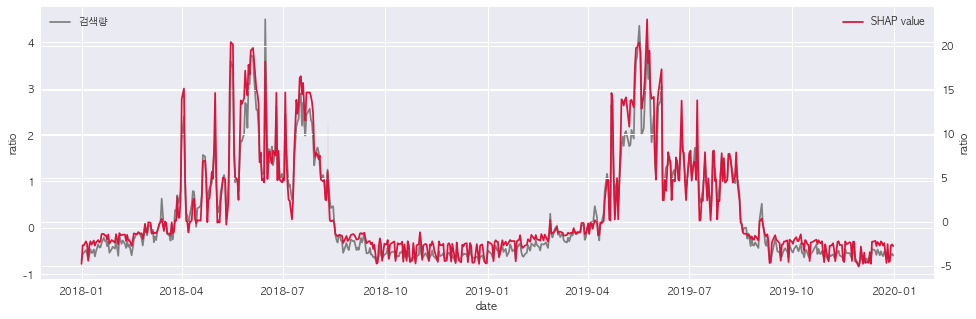

In [362]:
display_influence(a, b, 'ratio', '검색량')

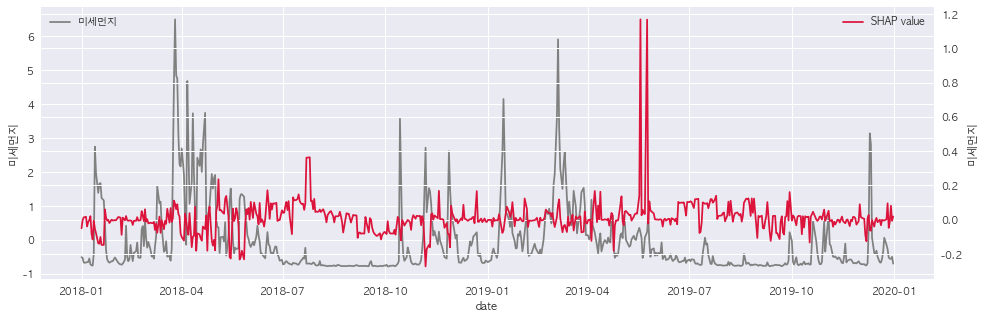

In [364]:
display_influence(a, b, '미세먼지', '미세먼지')

In [295]:
a, b = prep_shapvalue_for_trend(shap_values1, X_train1, e, product="데오드란트", target="20대 여성")

In [296]:
a.shape, b.shape

((618, 33), (618, 33))

In [297]:
b.head()

,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10_index,PM25_index,hm_max,sum_ss_hr,max_pa,1시간최대강수량,1시간최대습도,PM10,PM25,열지수,일별강수량,일조시간합,지점번호,체감온도,최고기온,최고현지기압,최저기온,평균기온,평균풍속,강수여부,폭염여부
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.703430,-1.260397,-0.512489,-0.611636,-0.690666,-0.354687,-1.432939,-1.430712,-1.381449,-0.387378,-0.450806,0.321078,0.368140,0.059594,-1.527428,0.656061,2.175767,-0.303935,-1.377049,0.032299,-0.153844,-1.425895,-0.291895,0.300061,0.000000,-1.251255,-1.374999,1.228085,-1.354618,-1.405428,-0.726315,0,0
2018-01-02,-0.572724,-0.928741,-0.537982,-0.578670,-0.690666,-0.349252,-1.395398,-1.366524,-1.410070,-0.387378,-0.450806,-0.067971,1.198028,1.118595,-0.283811,-0.060764,2.195753,-0.303935,-0.401357,-0.043017,-0.078117,-1.475815,-0.291895,0.171070,0.000000,-1.388066,-1.556766,1.416394,-1.281447,-1.451532,-0.066552,0,0
2018-01-03,-0.540047,-1.101498,-0.674784,-0.578670,-0.432132,-0.354687,-1.628216,-1.690623,-1.464565,-0.387378,-0.450806,1.037001,-0.247972,-0.217572,-1.792767,0.703274,2.233322,-0.303935,-1.552001,-0.257352,-0.302051,-1.773951,-0.291895,0.380681,0.000000,-1.749391,-1.756709,1.705135,-1.537547,-1.718937,0.593212,0,0
2018-01-05,-0.481229,-1.171528,-0.673965,-0.567682,-0.561400,-0.360121,-1.660343,-1.794489,-1.578970,-0.387378,-0.450806,-0.161400,0.076428,0.193946,-1.320426,-0.276093,2.196071,-0.303935,-1.383778,0.199456,0.084851,-1.773812,-0.291895,-0.107069,0.000000,-1.544038,-1.783974,1.516826,-1.683890,-1.718937,-0.726315,0,0
2018-01-06,-0.572724,-1.144443,-0.656517,-0.578670,-0.432132,-0.360121,-1.467795,-1.478563,-1.313092,-0.348791,-0.412031,0.511150,0.485046,0.857120,-0.529805,0.060043,2.045723,-0.303935,-1.390507,0.669150,0.803749,-1.598895,-0.291895,0.199286,0.000000,-1.470731,-1.574942,0.550171,-1.400351,-1.562182,-0.231493,0,0


In [289]:
shap.initjs()
shap.force_plot(explainer1.expected_value, a[0,:], b.iloc[0,:])

In [365]:
final2 = pd.read_csv("final_categorical_0621.csv", encoding="cp949")

In [366]:
corr_result = pd.read_csv("adf_corr_group_0617.csv", encoding="cp949")
corr_result.group.value_counts()

비정상_high    134
정상_high     130
정상_low       99
비정상_low      20
Name: group, dtype: int64

In [367]:
nonst_high = final2[final2.sm_cat.isin(list(corr_result[corr_result.group == "비정상_high"].sm_cat.unique()))]
nonst_low  = final2[final2.sm_cat.isin(list(corr_result[corr_result.group == "비정상_low"].sm_cat.unique()))]

st_high = final2[final2.sm_cat.isin(list(corr_result[corr_result.group == "정상_high"].sm_cat.unique()))]
st_low  = final2[final2.sm_cat.isin(list(corr_result[corr_result.group == "정상_low"].sm_cat.unique()))]


print(nonst_high.shape, nonst_low.shape, st_high.shape, st_low.shape)
final2.shape[0] == nonst_high.shape[0] + nonst_low.shape[0] + st_high.shape[0] + st_low.shape[0] 

(913113, 31) (142880, 31) (871890, 31) (640785, 31)


True

In [370]:
nonst_causal = pd.read_csv("nonstationary_causality.csv", encoding="cp949")

# qty > 0 인 데이터만 분석에 이용 
nonst_high = nonst_high[nonst_high.qty > 0]
print(nonst_high.shape)
print("*", nonst_high.sm_cat.nunique())

# Causality total > 0 인 데이터만 분석에 이용 
nonst_causal = nonst_causal[nonst_causal.total > 0]

print("* Causality Products : ", nonst_causal.sm_cat.nunique(), "\n")
print(nonst_causal.total.value_counts(), "\n")
nonst_causal.sort_values('total', ascending=False).head()

(766741, 31)
* 134
* Causality Products :  77 

1    31
3    13
2    13
5     6
4     6
7     4
6     4
Name: total, dtype: int64 



,sm_cat,PM10,PM25,avg_ws,sum_ss_hr,avg_ta,hm_max,max_pa,max_ta,min_ta,total
39,라디에이터,causality,causality,causality,None,causality,causality,None,causality,causality,7
102,초음파식 가습기,causality,causality,causality,None,causality,causality,None,causality,causality,7
86,온풍기,causality,causality,causality,None,causality,causality,None,causality,causality,7
5,가열식 가습기,causality,causality,causality,None,causality,causality,None,causality,causality,7
81,에어워셔,causality,None,None,causality,causality,causality,None,causality,causality,6


In [372]:
nonst_high = nonst_high[nonst_high.sm_cat.isin(list(nonst_causal.sm_cat.unique()))]
print(nonst_high.shape)
print("*", nonst_high.sm_cat.nunique())

(428524, 31)
* 77


In [377]:
ts = pd.read_csv("tsclustering_0620.csv", encoding='cp949')
ts_result = ts[["sm_cat", "cluster"]]

In [379]:
nonst_high = nonst_high.merge(ts_result, how='left', on="sm_cat")

In [380]:
nonst_high0 = nonst_high[nonst_high.cluster == 0]
nonst_high1 = nonst_high[nonst_high.cluster == 1]
nonst_high2 = nonst_high[nonst_high.cluster == 2]

nonst_high0.shape, nonst_high1.shape, nonst_high2.shape

((115843, 32), (200858, 32), (111823, 32))

In [381]:
nonst_high0.sort_values('qty', ascending=False).drop_duplicates('sm_cat', keep="first").head(30)

,date,sex,age,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,cnt,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,연,월,분기,요일,공휴일여부,주말여부,계절,cluster
302205,2019-06-03,F,30,식품,파/양파,829.000000,7.108315,29.784400,7.656820,1.724130,0.512820,2.120890,4.107277,19.958010,25.742156,13.853583,0.000000,0.000000,1.347469,42.581108,24.732976,68.066812,69.064885,885.720969,2019,6,2,0,0,0,1,0
297805,2019-05-27,F,40,뷰티,바디 클렌져,752.000000,74.418600,83.474920,4.647130,14.492750,2.439020,2.678570,3.021979,16.671500,20.151500,14.037406,16.413563,3.350667,3.150938,19.027720,10.182226,84.340583,0.760052,888.671333,2019,5,2,0,0,0,0,0
77439,2018-05-15,F,40,뷰티,선케어용 선밤,411.000000,0.000000,33.191270,37.013200,1.449270,1.219510,1.190470,3.186291,22.804531,28.829490,16.229042,0.000000,0.000000,1.514656,68.257646,40.456720,88.413875,57.063323,996.382865,2018,5,2,1,0,0,0,0
123694,2018-08-07,F,30,냉난방가전,휴대용 선풍기,410.000000,26.425900,19.866030,1.179110,10.344820,0.512820,2.439020,4.126760,26.340385,30.379344,23.808490,0.000000,0.000000,1.908344,23.714017,12.643833,80.337583,41.969469,901.210938,2018,8,3,1,0,0,1,0
282402,2019-05-01,F,30,식품,탄산수,279.000000,54.465270,35.305030,15.524460,4.741370,1.025640,0.106040,4.569073,13.883917,19.252188,9.684073,0.155271,0.155271,1.838677,54.350926,25.735227,81.426771,46.998323,885.197167,2019,5,2,2,0,0,0,0
378661,2019-10-14,F,40,냉난방가전,온수매트,260.000000,55.464390,31.638960,1.855480,0.000000,2.032520,1.190470,3.841427,13.852833,18.975802,9.688062,4.986927,1.432708,1.726208,29.697384,13.754406,78.838792,49.153000,904.127552,2019,10,4,0,0,0,2,0
26582,2018-02-14,F,20,식품,초코우유,242.000000,45.555550,27.818710,9.005630,8.036890,0.961530,0.222020,1.441068,5.549167,11.708375,-1.399990,0.000000,0.000000,3.008031,64.364510,29.557061,77.068271,40.546125,999.667552,2018,2,1,2,0,0,3,0
74321,2018-05-09,F,30,식품,허브차,226.000000,43.333330,26.755580,11.756050,3.448270,0.512820,0.212080,2.679031,14.103583,19.021740,9.992948,0.018000,0.018000,2.433375,28.263189,11.874999,81.081479,54.078823,1007.479281,2018,5,2,2,0,0,0,0
125921,2018-08-12,F,30,식품,기타 주스류,216.000000,0.000000,16.190820,0.731290,4.310340,0.512820,1.802750,2.870080,26.120208,30.105208,22.682448,3.084635,1.646385,1.923125,20.490159,11.453968,79.855260,41.804969,901.984333,2018,8,3,6,0,1,1,0
85254,2018-05-29,M,30,뷰티,데오드란트,159.000000,56.231450,39.897260,18.599450,23.711340,3.333330,0.630370,2.979292,21.445615,26.619062,17.659719,0.764458,0.389302,1.530260,49.638986,29.696089,92.926594,38.932740,996.699083,2018,5,2,1,0,0,0,0


In [382]:
nonst_high1.sort_values('qty', ascending=False).drop_duplicates('sm_cat', keep="first").head(30)

,date,sex,age,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,cnt,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,연,월,분기,요일,공휴일여부,주말여부,계절,cluster
261495,2019-03-28,F,40,뷰티,기초 화장용 크림,1268.000000,36.458330,34.292000,28.045450,1.449270,0.813000,0.297610,3.022098,9.743438,14.003750,7.003854,0.551042,0.110208,1.874333,61.293941,36.032146,79.766845,41.534312,900.603521,2019,3,1,3,0,0,0,1
226159,2019-01-28,F,40,식품,감귤/한라봉/오렌지,1160.000000,50.067033,34.743580,13.189890,0.483090,1.626010,0.000000,2.396613,2.736750,6.614615,-0.837875,0.163927,0.129958,2.770969,59.205529,20.612313,67.565854,40.926198,891.843177,2019,1,1,0,0,0,3,1
365043,2019-09-22,F,40,뷰티,기능성 아이케어 화장품,933.000000,25.000000,43.569190,0.528010,4.347820,6.504060,7.291660,2.998205,15.652906,16.997948,14.404000,53.002531,6.360323,4.383625,8.096932,3.476311,82.054427,0.044083,884.711667,2019,9,3,6,0,1,2,1
200242,2018-12-17,F,30,뷰티,기초 화장용 로션,407.000000,73.684210,16.427120,11.017910,0.000000,1.025640,0.106040,2.433473,3.342062,6.943250,0.285677,0.034042,0.022625,2.077031,53.939384,32.330842,77.554552,38.938812,874.347656,2018,12,4,0,0,0,3,1
197894,2018-12-13,F,40,식품,루테인/눈 영양제,366.000000,57.522600,35.547960,3.098740,0.966180,1.626010,0.297610,2.220886,0.535740,4.958042,-3.102323,0.467083,0.256292,2.299396,32.822376,20.295136,69.384000,30.121312,884.250177,2018,12,4,3,0,0,3,1
169338,2018-10-27,F,40,냉난방가전,히터,349.000000,44.137930,22.059770,1.585970,0.966180,0.000000,0.892850,1.830871,9.824354,12.900021,7.301302,0.278635,0.175792,2.959990,25.518842,8.330427,67.184396,40.347438,897.279052,2018,10,4,5,0,1,2,1
275373,2019-04-20,F,40,뷰티,기초 화장용 미스트,316.000000,18.988760,36.727720,10.136500,10.144920,0.406500,0.000000,3.055719,13.795323,19.065167,8.645865,0.098000,0.052063,1.714073,42.428098,19.050014,77.921333,54.239448,914.111323,2019,4,2,5,0,1,0,1
355449,2019-09-04,F,30,뷰티,핸드크림,310.000000,33.877990,45.672550,0.673520,17.672410,9.743580,13.679740,5.066730,20.756125,23.278896,19.019771,13.031365,6.673135,1.344937,14.333433,6.590033,85.796688,2.337990,883.004021,2019,9,3,2,0,0,2,1
351100,2019-08-28,F,20,뷰티,색조 메이크업 아이섀도우,298.000000,69.325150,34.756420,1.072330,16.864290,0.961530,0.577260,3.750678,20.406427,23.409562,18.419677,2.363219,0.831271,1.157229,22.671395,13.316422,80.342344,15.185604,842.325229,2019,8,3,2,0,0,1,1
396151,2019-11-11,F,30,뷰티,바디 보습제,280.000000,45.454540,43.741210,3.697250,4.310340,1.025640,0.106040,2.553091,11.512198,15.625000,8.432906,1.076854,0.821667,2.420792,28.939126,13.913564,82.219000,33.594427,911.192010,2019,11,4,0,0,0,2,1


In [383]:
nonst_high2.sort_values('qty', ascending=False).drop_duplicates('sm_cat', keep="first").head(30)

,date,sex,age,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,cnt,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,연,월,분기,요일,공휴일여부,주말여부,계절,cluster
66707,2018-04-26,F,30,식품,비타민,451.000000,71.206220,28.936880,32.533850,0.000000,1.025640,0.212080,2.324359,14.765010,21.726281,7.900042,0.000000,0.000000,1.684000,46.757832,29.171362,82.403083,65.376677,983.232385,2018,4,2,3,0,0,0,2
420930,2019-12-19,F,40,식품,콜라겐/코큐텐 영양제,430.000000,36.488975,36.942220,2.250030,0.000000,0.406500,0.148800,3.289845,2.506104,6.400667,-0.091594,0.000000,0.000000,2.516250,24.197120,14.409307,62.623146,43.890750,921.420719,2019,12,4,3,0,0,3,2
410459,2019-12-03,F,30,식품,어린이영양제,318.000000,65.116270,39.669580,1.422680,1.724130,1.025640,0.636260,4.789529,2.768896,6.339010,-1.249323,0.269188,0.171615,1.692771,21.220462,11.509635,71.924333,30.687604,920.679156,2019,12,4,1,0,0,3,2
241888,2019-02-23,F,40,식품,오메가3/스쿠알렌 영양제,250.000000,17.190535,17.287120,20.727810,0.000000,0.813000,0.297610,2.036226,5.694031,12.108406,0.590021,0.000000,0.000000,1.498292,58.328928,40.333197,75.056885,45.576906,909.098365,2019,2,1,5,0,1,3,2
221708,2019-01-20,F,30,식품,캡슐/POD커피,234.000000,36.975520,13.347520,16.614550,0.431030,1.538460,0.106040,1.966498,1.896406,5.378302,-1.816458,0.081250,0.107688,3.047021,44.134177,25.353820,74.191042,45.822021,890.880698,2019,1,1,6,0,1,3,2
86014,2018-05-30,F,30,냉난방가전,온열매트,205.000000,2.024740,39.876580,26.360750,12.068960,1.025640,0.424170,3.348522,20.684146,25.919635,17.020063,3.494490,2.324156,1.791708,48.339285,29.218516,92.958521,34.934323,995.892323,2018,5,2,2,0,0,0,2
243085,2019-02-25,F,30,식품,요거트/발효유,200.000000,39.106910,37.332050,21.179170,0.000000,0.000000,0.000000,3.284927,6.113208,11.372115,2.199104,0.000000,0.000000,1.682948,65.565682,44.976472,74.507010,46.971729,906.820552,2019,2,1,0,0,0,3,2
17111,2018-01-29,F,30,식품,칼슘/철분 영양제,126.000000,37.353550,42.495310,2.917420,0.000000,1.025640,0.318130,2.201473,-5.156646,-1.230198,-7.823729,0.109260,0.070698,3.295042,42.993105,19.215288,60.608354,50.848865,1016.657750,2018,1,1,0,0,0,3,2
420297,2019-12-18,F,40,뷰티,클렌징 로션,122.000000,44.444440,46.100870,3.673390,0.966180,0.813000,0.297610,3.779982,4.572635,7.967583,2.391146,0.277604,0.111042,2.405031,31.894203,21.361321,72.896146,33.334021,918.335510,2019,12,4,2,0,0,3,2
389921,2019-11-01,F,30,식품,쌈채소,90.000000,60.144920,44.069280,36.952570,1.724130,0.512820,0.318130,2.691107,14.053781,19.596323,9.933854,0.000000,0.000000,1.396979,96.591928,34.972158,80.835167,49.959062,916.133167,2019,11,4,4,0,0,2,2
